# Importing libraries

In [ ]:
!pip install hazm

In [2]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from functools import reduce
from hazm import *
import copy

In [ ]:
def import_data(path):
    file_path = path
    data = pd.read_json(path)
    return data.T

In [ ]:
# Import CSV file
from google.colab import files
uploaded = files.upload()

# Preprocessing



*  Normalization

* Extracting Tokens

* Stemming
* Removing Stopwords



In [ ]:
data = import_data('./IR_data_news_12k.json')

In [ ]:
content = data['content']

In [ ]:
def normalize(text):
    normalizer = Normalizer()
    return normalizer.normalize(text)

In [ ]:
def tokenizer(text):
    return word_tokenize(text)

In [ ]:
def stem(token):
    stemmer = Stemmer()
    return stemmer.stem(token)

In [ ]:
def stem_tokens(tokens):
    return [stem(token) for token in tokens]

In [ ]:
def filter_stop_words(tokens):
    STOP_WORDS = stopwords_list()
    return [token for token in tokens if token not in STOP_WORDS]

In [ ]:
def preprocess(text, debug = False):
    normalized_text = normalize(text)
    tokens = tokenizer(normalized_text)
    stemmed_tokens = stem_tokens(tokens)
    output = filter_stop_words(stemmed_tokens)
    
    if(debug):
        print(text)
        print(normalized_text)
        print(tokens)
        print(stemmed_tokens)
        print(output)

    return output

#Positional index construction

In [ ]:
def preprocess_all(docs):
    """
    {term: [count, {docId: Array of positions}]}
    """
    positional_index = {}
    
    for docId, doc in enumerate(docs):
        terms = preprocess(doc)
        
        for index, term in enumerate(terms):
            
            if term not in positional_index:
                positional_index[term] = [1, {docId: [index]}]
            else:
                positional_index[term][0] = positional_index[term][0] + 1
                
                if docId in positional_index[term][1]:
                    positional_index[term][1][docId].append(index)
                else:
                    positional_index[term][1][docId] = [index]
                    
    return positional_index

In [ ]:
def get_term_count(term, docs, positional_index):
    for docId, doc in enumerate(docs):
        if positional_index[term]:
            if positional_index[term][1][docId]:
                return len(positional_index[term][1][docId])
            else:
                return 0
        else:
            return 0

In [ ]:
def extract_tokens(query_tokens):
    simple_tokens = []
    not_tokens = []
    phrase_tokens = []
    i = 0
    phrase_index = 0
    
    while i < len(query_tokens):
        if query_tokens[i] == '!' :
            not_tokens.append(query_tokens[i + 1])
            i = i + 2
            continue
        elif query_tokens[i] == '«':
            phrase_index = i + 1
        elif query_tokens[i] == '»':
            phrase = query_tokens[phrase_index:i]
            
            for token in ['«', *phrase]:
                simple_tokens.remove(token)
                
            i = i + 1
            phrase_tokens.append(phrase)
            continue
        simple_tokens.append(query_tokens[i])
        i = i + 1
    
    return (simple_tokens, not_tokens, phrase_tokens)

In [ ]:
positional_index = preprocess_all(content)

#Query processing

In [ ]:
def search(query, positional_index):
    query_tokens = preprocess(query)
    (simple_tokens, not_tokens, phrase_tokens) = extract_tokens(query_tokens)
    docs = {}
    for token in simple_tokens:
        token_entry = positional_index.get(token)
        if token_entry is None:
            continue
            
        token_docs = list(token_entry[1])
        for doc in token_docs:
            if doc not in docs:
                docs[doc] = 1
            else:
                docs[doc] = docs[doc] + 1

    for token in not_tokens:
        token_entry = positional_index.get(token)
        if token_entry is None:
            continue
            
        token_docs = list(token_entry[1])
        for doc in token_docs:
            if doc in docs:
                del docs[doc]

    for phrase in phrase_tokens:
        incident = {}

        for index, token in enumerate(phrase):
            token_entry = positional_index.get(token)
            
            if token_entry is None:
                break
                
            token_docs = token_entry[1]
            
            if index == 0:
                incident = token_docs
            else:
                for doc in list(incident):
                    if doc not in token_docs:
                        del incident[doc]
                        
                # Positions of current token in incident docs
                doc_positions = {key: token_docs[key] for key in token_docs if key in incident} 
            
                for doc in list(incident):
                    positions = incident[doc] # Positions of first token of phrase
                    maintainedOrder = False
                    
                    for position in positions:
                        if maintainedOrder:
                            break

                        maintainedOrder = (position + index) in doc_positions[doc]
                    if not maintainedOrder:
                        del incident[doc]
                        
        for doc in incident:
            if doc not in docs :
                docs[doc] = 1
            else:
                docs[doc] = docs[doc] + 1

    docs = sorted(docs.items(), key=lambda x:x[1], reverse=True)
    return [doc[0] for doc in docs]

In [ ]:
def show_result(results, data):
    return data.loc[results, ['url', 'title']]

#Search results


*  Common Normal Queries
*Boolean Queries (NOT)
*Phrase Queries
* Complex Combination of All Types of Queries
* Rare Queries



In [ ]:
# Common Normal Query
show_result(search("تحریم‌های آمریکا علیه ایران", positional_index), data)

,url,title
6845,https://www.farsnews.ir/news/14001223001080/اح...,احتمال مبادله نازنین زاغری در ازای 530میلیون دلار
6926,https://www.farsnews.ir/news/14001222000749/مت...,متکی: آمریکا با ابزار ناتو به دنبال تجزیه روسی...
6929,https://www.farsnews.ir/news/14001222000450/تو...,توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
6942,https://www.farsnews.ir/news/14001222000366/بی...,بیانیه نمایندگان مجلس/ رفع کاغذی تحریم‌ها تأمی...
6945,https://www.farsnews.ir/news/14001222000327/ای...,ایستگاه آخر کدخداپرستان کجاست؟
...,...,...
12167,https://www.farsnews.ir/news/14000725000333/نا...,نامه 160 نماینده به رئیس‌جمهور/ دولت برای استف...
12172,https://www.farsnews.ir/news/14000725000277/بر...,برنامه‌های نهاد رهبری در دانشگاه‌ها برای حمایت...
12177,https://www.farsnews.ir/news/14000725000258/مو...,موافقت مجلس با لایحه «پروتکل حفاظت از تنوع زیس...
12186,https://www.farsnews.ir/news/14000725000158/در...,در هر هفته‌ 17 میلیون دز واکسن به کشور وارد می...


In [ ]:
# Boolean Query (NOT)
show_result(search("تحریم‌های آمریکا ! ایران", positional_index), data)

,url,title
6938,https://www.farsnews.ir/news/14001222000379/مح...,محو رژیم صهیونیستی از آرمان‌های نظام اسلامی حذ...
7252,https://www.farsnews.ir/news/14001203000366/تج...,تجربه نشان داده به عهد آمریکا در مذاکرات نمی‌ش...
7268,https://www.farsnews.ir/news/14001205000615/حت...,حتی اگرتوافق هم بشود نباید معیشت را به وعده آم...
7328,https://www.farsnews.ir/news/14001130000933/کم...,کم‌توجهی به بیانات رهبر انقلاب در برجام تبعات ...
7491,https://www.farsnews.ir/news/14001203000383/مس...,مسائل اقتصادی کشور را معطل نتیجه مذاکرات نمی‌‌...
...,...,...
11793,https://www.farsnews.ir/news/14000805000869/مد...,مدیریت مشکل بنزین امسال نتیجه تفکر انقلابی و ب...
11909,https://www.farsnews.ir/news/14000802000225/آی...,آیت‌الله رئیسی: آمریکا و اروپا دچار بحران در ت...
11957,https://www.farsnews.ir/news/14000730000189/خط...,خطیب جمعه تهران: متجاوزان به اموال عمومی نباید...
12125,https://www.farsnews.ir/news/14000726000302/آت...,آتش ترور دامان مسببان آن را خواهد گرفت و موجب ...


In [ ]:
# Phrase Query
show_result(search('"کنگره ضدتروریست"', positional_index), data)

,url,title
6929,https://www.farsnews.ir/news/14001222000450/تو...,توضیحات یک منبع آگاه درباره وقفه مذاکرات وین


In [ ]:
# Complex Combination of All Types of Query
show_result(search('"تحریم هسته‌ای" آمریکا ! ایران', positional_index), data)

,url,title
85,https://www.farsnews.ir/news/14001223000292/با...,با پردرآمدترین ورزشکاران جهان آشنا شوید؛ از MM...
226,https://www.farsnews.ir/news/14001221000109/بم...,بمب خبری بازگشت مسی به بارسلونا خنثی شد/پای جا...
300,https://www.farsnews.ir/news/14001220000373/من...,منچستریونایتد به دنبال بهترین بازیکن دنیا / زو...
424,https://www.farsnews.ir/news/14001218000297/حض...,حضور بازیکن اوکراینی در لیگ ایران پس از جنگ با...
451,https://www.farsnews.ir/news/14001217000994/را...,راهیابی بانوی سنگنورد کشورمان به مسابقات جهانی...
...,...,...
11909,https://www.farsnews.ir/news/14000802000225/آی...,آیت‌الله رئیسی: آمریکا و اروپا دچار بحران در ت...
11957,https://www.farsnews.ir/news/14000730000189/خط...,خطیب جمعه تهران: متجاوزان به اموال عمومی نباید...
12125,https://www.farsnews.ir/news/14000726000302/آت...,آتش ترور دامان مسببان آن را خواهد گرفت و موجب ...
12154,https://www.farsnews.ir/news/14000725000758/جم...,جمع‌بندی گزارش کمیسیون اصل 90 درباره قطعی برق ...


In [ ]:
# Rare Query
show_result(search('اورشلیم ! صهیونیست', positional_index), data)

,url,title


# Testing Zipf's law
Testing Zipf's law on the dataset **with and without filtering stop words**

In [ ]:
def zipf_law(docs, stops = False):
    total_tokens = {}
    for doc in docs:
        tokens = tokenizer(doc)
        
        if stops:
            tokens = filter_stop_words(tokens)
            
        for token in tokens:
            count = total_tokens.get(token)
            if count is None:
                total_tokens[token] = 1
            else:
                total_tokens[token] = count + 1
        
    sorted_tokens = dict(sorted(total_tokens.items(), key=lambda x:x[1], reverse=True))
    
    frequency_log = []
    rank_log = []
    rank = 1
    
    for token, frequency in sorted_tokens.items():
        frequency_log.append(math.log(frequency))
        rank_log.append(math.log(rank))
        rank = rank + 1

    plt.plot(rank_log, frequency_log)
    plt.ylabel("log cf")
    plt.xlabel("log rank")
    plt.show()

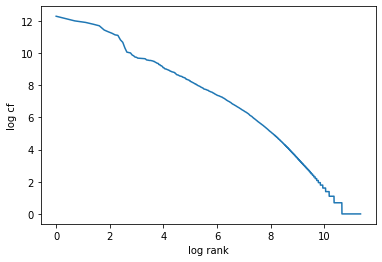

In [ ]:
zipf_law(content)

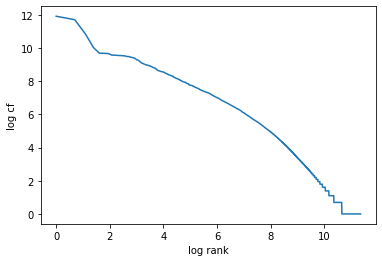

In [ ]:
zipf_law(content, True)

# Testing Heap's law
Testing Heap's law on the dataset **with and without stemming**

In [ ]:
def heaps_law(docs, stemming = False):
    steps = [500, 1000, 1500, 2000]
    total = []
    sets = []
    
    for step in steps:
        total_tokens = []
        total_tokens_set = set()

        for doc in docs[0: step]:
            tokens = tokenizer(doc)

            if(stemming):
                tokens = stem_tokens(tokens)

            for token in tokens:
                total_tokens.append(token)
                total_tokens_set.add(token)

        total.append(len(total_tokens))
        sets.append(len(total_tokens_set))
    
    plt.plot(total, sets)
    plt.xlabel("Tokens")
    plt.ylabel("Unique Terms")
    plt.show()

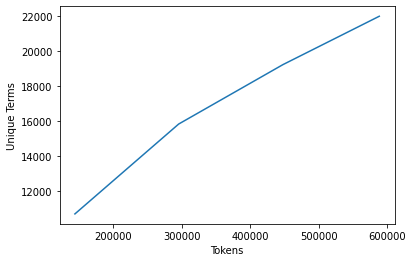

In [ ]:
heaps_law(content)

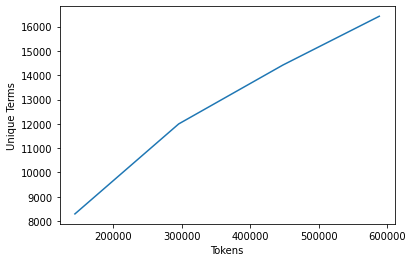

In [ ]:
heaps_law(content, True)

# Tf-idf indexing

In [ ]:
def idf_index(docs, positional_index):
    """
    {term: [count, {docId: Array of positions}, idf]}
    """
    output = copy.deepcopy(positional_index)
    
    for token in output:
        df = len(output[token][1])
        idf = math.log(len(docs) / df)
        output[token].append(idf)
        
    return output

In [ ]:
idf = idf_index(content, positional_index)

In [ ]:
def doc_term_frequency(doc):
    """
    {term: frequency}
    """
    output = {}
    tokens = preprocess(doc)
    
    for index, term in enumerate(tokens):
        if term not in output:
            output[term] = 1
        else:
            output[term] = output[term] + 1
            
    return output

In [ ]:
def docs_frequency(docs):
    """
    {docId: {term: frequency}}
    """
    return [doc_term_frequency(doc) for doc in docs]

In [ ]:
docs_term_frequency = docs_frequency(content)

In [ ]:
def term_frequency(term, doc_term_frequency):
    if term not in doc_term_frequency:
        return 0
    return 1 + math.log(doc_term_frequency[term])

# Vectorizing tf-idf index

In [ ]:
def create_vector(positional_index, doc_token):
    vector = []
    for token in positional_index:
        tf = term_frequency(token, doc_token)
        idf = positional_index[token][2]
        tf_idf = tf * idf
        vector.append(tf_idf)
    return vector

# Similarity search based on cosine similarity

In [ ]:
def calculate_similarity(vector1, vector2):
    dot_product = np.dot(np.array(vector1), np.array(vector2))
    length_product = np.linalg.norm(np.array(vector1)) * np.linalg.norm(np.array(vector2))

    return 0 if length_product == 0 else dot_product / length_product

In [ ]:
def similarity_search(champion_index, docs_frequency, K, query):
    query_tokens = doc_term_frequency(query)
    similarity = {}
    
    for docId in range(len(docs_frequency)):
        doc_vector = create_vector(champion_index, docs_frequency[docId])
        query_vector = create_vector(champion_index, query_tokens)
        similarity[docId] = calculate_similarity(query_vector, doc_vector)
        
    sorted_similarity = sorted(similarity.items(), key=lambda x: x[1], reverse=True)
    return [doc[0] for doc in sorted_similarity[0: K]]

## Adding champion list

Using champion list to speed up cosine computation

In [ ]:
def champion_index(idf_index, docs_frequency, K):
    """
    {term: [count, {docId: Array of positions}, idf, Array of champions]}
    """
    output = copy.deepcopy(idf_index)
    
    for i, token in enumerate(output):
        token_champions = []
        tf_dict = {}
        
        for docId, doc_term_frequency in enumerate(docs_frequency):
            tf = term_frequency(token, doc_term_frequency)
            if tf > 0:
                tf_dict[docId] = tf
            
        sorted_tf_dict = sorted(tf_dict.items(), key=lambda x: x[1], reverse=True)
        
        for sorted_item in sorted_tf_dict[0: K]:
            token_champions.append(sorted_item[0])
        output[token].append(token_champions)
        print(i / len(output))
        
    return output

In [ ]:
def similarity_champion_search(champion_index, docs_frequency, K, query):
    query_tokens = doc_term_frequency(query)
    champs = []
    
    for token in query_tokens:
        if token in champion_index:
            for doc in champion_index[token][3]:
                champs.append(doc) 
                
    champ_similarity = {}
    
    for docId in champs:
        doc_vector = create_vector(champion_index, docs_frequency[docId])
        query_vector = create_vector(champion_index, query_tokens)
        champ_similarity[docId] = calculate_similarity(query_vector, doc_vector)
        
    sorted_similarity = sorted(champ_similarity.items(), key=lambda x: x[1], reverse=True)
    return [doc[0] for doc in sorted_similarity[0: K]]

In [ ]:
champion_list = champion_index(idf, docs_term_frequency, 10)

#Search results with **ranked retrieval**



In [ ]:
show_result(similarity_champion_search(champion_list, docs_term_frequency, 10, "ایران"), data)

,url,title
2831,https://www.farsnews.ir/news/14001116000751/اف...,افشای دلایل جدایی پروفسور از هندبال ایران| فرن...
10757,https://www.farsnews.ir/news/14000821000097/را...,راهبرد «مذاکره هسته‌ای نداریم» چگونه تأمین کنن...
6929,https://www.farsnews.ir/news/14001222000450/تو...,توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
9882,https://www.farsnews.ir/news/14000919000089/چر...,چرا غرب مجبور به تمکین از خواسته‌ تهران است؟/ ...
12165,https://www.farsnews.ir/news/14000724000463/گف...,گفت‌وگو با کارشناس مسائل قفقاز| منازعه آذربایج...
9742,https://www.farsnews.ir/news/14000924000773/مر...,مرکز پژوهش‌های مجلس: مذاکرات وین به توافقی زود...
9496,https://www.farsnews.ir/news/14000926000385/گف...,گفت‌وگوی مشروح | ترقی: آمریکا شروط ایران را نپ...
11864,https://www.farsnews.ir/news/14000803000676/اه...,اهرم‌سازی از افغانستان در برجام/ نقطه عزیمت آم...
11928,https://www.farsnews.ir/news/14000801000437/نا...,نامه جمعی از اساتید و متخصصان/ آقای رئیس‌جمهور...
7778,https://www.farsnews.ir/news/14001121000352/دع...,دعوت احزاب و شخصیت‌های سیاسی از مردم برای حضور...


In [ ]:
show_result(similarity_champion_search(champion_list, docs_term_frequency, 10, "تحریم ایران"), data)

,url,title
10757,https://www.farsnews.ir/news/14000821000097/را...,راهبرد «مذاکره هسته‌ای نداریم» چگونه تأمین کنن...
7059,https://www.farsnews.ir/news/14001218000420/مذ...,مذاکره‌کنندگان مراقب باشند تجربه تلخ برجام و ب...
7731,https://www.farsnews.ir/news/14001123000508/نش...,نشست بررسی روند مذاکرات| آمریکا استاد دور زدن‌...
6929,https://www.farsnews.ir/news/14001222000450/تو...,توضیحات یک منبع آگاه درباره وقفه مذاکرات وین
6963,https://www.farsnews.ir/news/14001221000788/سی...,سیاست‌گذاری‌های ارزی دهه 90 همواره در جهت تضعی...
9418,https://www.farsnews.ir/news/14001005000843/با...,بازخوانی | بیانات رهبر انقلاب در دیدار دست‌اند...
9742,https://www.farsnews.ir/news/14000924000773/مر...,مرکز پژوهش‌های مجلس: مذاکرات وین به توافقی زود...
11864,https://www.farsnews.ir/news/14000803000676/اه...,اهرم‌سازی از افغانستان در برجام/ نقطه عزیمت آم...
11341,https://www.farsnews.ir/news/14000816000568/ما...,ماجرای دستگیری دو دانشمند ایرانی در آمریکا/ س...
10806,https://www.farsnews.ir/news/14000808000646/دو...,دولت خاتمی ۶ میلیارد دلار پول نفت را به خزانه ...


In [ ]:
show_result(similarity_champion_search(champion_list, docs_term_frequency, 10, "صهیونیست"), data)

,url,title
6330,https://www.farsnews.ir/news/14001002000158/مح...,محکومیت حضور کاروان ورزشی رژیم صهیونستی در اما...
6621,https://www.farsnews.ir/news/14000928000230/ات...,اتفاق عجیب در ادامه عادی سازی روابط رژیم اشغال...
6524,https://www.farsnews.ir/news/14000929000102/مه...,مهدوی‌کیا حامل پرچم رژیم اشغالگر شد!/ خشم صهیو...
6451,https://www.farsnews.ir/news/14000929000460/مو...,موج اعتراضات از ایران به عراق رسید/ محکومیت یو...
6174,https://www.farsnews.ir/news/14001004000131/مه...,مهدوی‌کیا به جای عذرخواهی در دام صهیونیست‌ها ا...
6115,https://www.farsnews.ir/news/14001005000171/چر...,چرا ماجرای مهدوی‌کیا اهمیت دارد؟
11974,https://www.farsnews.ir/news/14000729000313/پی...,پیروزی‌های جبهه مقاومت با وحدت در امت واحده اس...
9440,https://www.farsnews.ir/news/14001005000248/مه...,مهدوی‌کیا، وزارت ورزش و سؤالات بی‌پاسخ در قبال...
7806,https://www.farsnews.ir/news/14001120000821/کا...,کارشکنی نفوذی‌ها و بی عرضگی تفکر غرب‌گرا دلیل ...
9309,https://www.farsnews.ir/news/14001008000293/شر...,شرح فتنه‌ تغلب/ چه کسی جواب خون‌ها را می‌دهد؟


In [ ]:
show_result(similarity_champion_search(champion_list, docs_term_frequency, 10, "پرسمان چند کلمه‌ای"), data)

,url,title
666,https://www.farsnews.ir/news/14001215000961/تا...,تارتار: بی دلیل نیست فولاد در اهواز شکست نمی خ...
1032,https://www.farsnews.ir/news/14001209001155/رب...,ربیعی: روی اشتباهات خودمان به پرسپولیس باختیم/...
779,https://www.farsnews.ir/news/14001214000618/مه...,مهر تایید انتقال امباپه به رئال در اردوی دشمن
682,https://www.farsnews.ir/news/14001215000889/عن...,عنایتی: توانستیم از یک بازی سخت امتیاز بگیریم/...
7030,https://www.farsnews.ir/news/14001219000158/بر...,برای نابودی فساد باید به سمت تحقق عدالت برویم
11896,https://www.farsnews.ir/news/14000803000174/با...,باید در عرصه تقریب به نوسازی و تولید نظریه دست...
1824,https://www.farsnews.ir/news/14001130000599/سا...,ساکت: فراز و نشیب‌های سپاهان برای ما هم تلخ بو...
11287,https://www.farsnews.ir/news/14000818000258/سر...,سرلشکر موسوی: نیروهای مسلح پشتیبان دیپلمات‌ها ...
7757,https://www.farsnews.ir/news/14001122000194/رئ...,رئیسی: امید ما به مردم است، نه وین و نیویورک
11052,https://www.farsnews.ir/news/14000823000877/کا...,کامل‌ترین کتاب فقهی حضرت آیت‌الله خامنه‌ای در ...


In [ ]:
show_result(search('تحریم ایران', positional_index), data)

,url,title
127,https://www.farsnews.ir/news/14001222000684/رئ...,رئیس فیفا تماشاگر بازی رقبای ایران می شود
786,https://www.farsnews.ir/news/14001214000461/رئ...,رئیس فدراسیون تنیس روی‌میز: ملی‌پوشان ناراضی ن...
1094,https://www.farsnews.ir/news/14001209000780/در...,درخواست همگروه ایران برای تغییر برنامه‌اش در ا...
1122,https://www.farsnews.ir/news/14001209000334/VA...,VAR به عراق رسید/دیدار رقبای ایران با کمک داور...
1315,https://www.farsnews.ir/news/14001207000109/هم...,همگروه ایران برای رفع تحریم دست به دامن عربستا...
...,...,...
12186,https://www.farsnews.ir/news/14000725000158/در...,در هر هفته‌ 17 میلیون دز واکسن به کشور وارد می...
12187,https://www.farsnews.ir/news/14000725000143/قا...,قالیباف: محرمانه بودن اموال مسئولان مصوبه مجلس...
12190,https://www.farsnews.ir/news/14000725000113/جز...,جزئیات نشست غیرعلنی مجلس/ امیرعبداللهیان: اقدا...
12198,https://www.farsnews.ir/news/14000724000611/نق...,نقدی بر یادداشت «مرزبندی گفتمانی با طالبان»/ و...


In [ ]:
show_result(search("پرسمان چند کلمه‌ای", positional_index), data)

,url,title
7707,https://www.farsnews.ir/news/14001124000456/تف...,تفکر انجمن حجتیه نتیجه ترس مقابل دربار شاه بود
7757,https://www.farsnews.ir/news/14001122000194/رئ...,رئیسی: امید ما به مردم است، نه وین و نیویورک
10122,https://www.farsnews.ir/news/14000916000283/نم...,نماینده بسیج دانشجویی در دیدار با رئیسی: شرایط...
10278,https://www.farsnews.ir/news/14000912000414/ما...,ماجرای هماهنگی با حاکم بلوچستان پاکستان برای آ...
11369,https://www.farsnews.ir/news/14000816000476/در...,در نشست علنی امروز مجلس چه گذشت؟/گام نخست وکلا...
...,...,...
11945,https://www.farsnews.ir/news/14000722000210/چر...,چرا مخالفان بنی‌صدر، یکباره حامی او شدند؟/ اول...
11974,https://www.farsnews.ir/news/14000729000313/پی...,پیروزی‌های جبهه مقاومت با وحدت در امت واحده اس...
12050,https://www.farsnews.ir/news/14000727000934/شو...,شورای هماهنگی تبلیغات اسلامی: با هم پیمانی با ...
12063,https://www.farsnews.ir/news/14000727000591/رو...,روایت رئیس دفتر نظامی رهبر انقلاب از نقش سرلشک...
